In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

In [ ]:
%%capture
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

In [ ]:
%%capture
! pip install datasets transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
from pathlib import Path
import re

def targeted_clean_sentences(sent_list):
    """
    Remove sentences containing JavaScript or irrelevant patterns.
    """
    unwanted_patterns = [
        r"var ", r"s_context", r"\$", r"require", r"function", r"insert", r"webmd", r"disable", r"ads", r"module"
    ]
    # Compile regex for unwanted patterns
    unwanted_regex = re.compile("|".join(unwanted_patterns), re.IGNORECASE)

    # Filter out sentences matching unwanted patterns
    clean_sent_list = [sentence for sentence in sent_list if not unwanted_regex.search(sentence)]
    return " ".join(clean_sent_list)  # Join the cleaned sentences

def load_and_preprocess_data_with_targeted_cleaning(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    texts, queries, answers = [], [], []

    for item in data['data']:
        for paragraph in item['paragraphs']:
            # Clean the context
            context = targeted_clean_sentences(paragraph['sent_list'])

            for qa in paragraph['qas']:
                question = qa['question']
                truncated_answers = []
                truncated_answer_starts = []

                for ans in qa['answers']:
                    first_line = ans['text'].split('.')[0] + '.'  # Take only the first line
                    start = context.find(first_line)

                    if start != -1:  # If the first line is found in the cleaned context
                        truncated_answers.append(first_line)
                        truncated_answer_starts.append(start)
                    else:  # Fall back to the original full answer
                        truncated_answers.append(ans['text'])
                        truncated_answer_starts.append(ans['answer_start'])

                answers_obj = {
                    "text": truncated_answers,
                    "answer_start": truncated_answer_starts
                }

                for i, answer_start in enumerate(answers_obj["answer_start"]):
                    answer_text = answers_obj["text"][i]
                    answer_end = answer_start + len(answer_text)

                    # Determine the trimming window
                    start_idx = max(0, answer_start - 128)  # Include 128 tokens before the answer
                    end_idx = min(len(context), answer_end + 128)  # Include 128 tokens after the answer

                    trimmed_context = context[start_idx:end_idx]

                    # Adjust the answer start to the new trimmed context
                    adjusted_answer_start = answer_start - start_idx

                    # Append to the lists
                    texts.append(trimmed_context)
                    queries.append(question)
                    answers.append({
                        "text": [answer_text],
                        "answer_start": [adjusted_answer_start]
                    })

    return texts, queries, answers

# Process train data
train_path = Path('/content/drive/MyDrive/646 Project/mashqa_dataset/train_webmd_squad_v2_consec.json')
train_texts, train_queries, train_answers = load_and_preprocess_data_with_targeted_cleaning(train_path)

# Process validation data
val_path = Path('/content/drive/MyDrive/646 Project/mashqa_dataset/val_webmd_squad_v2_consec.json')
val_texts, val_queries, val_answers = load_and_preprocess_data_with_targeted_cleaning(val_path)


In [ ]:
print("Passage: ",train_texts[0])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  ecked regularly, as some people may develop a case of chronic angle-closure glaucoma later in life, even after laser treatment. If the glaucoma does not respond to medication, or if you cannot tolerate the side effects, your doctor may change medications or recommend one of several surgical techniques: Laser trabeculoplasty creates small laser burns in the area where the fluid drains, improving the outflow rate of aqueous fluid. This relatively brief procedure can often be done in an ophthalmologist's clinic. Trabeculectomy is a surgical procedure that c
Query:  What surgical techniques are used to treat glaucoma?
Answer:  {'text': ['If the glaucoma does not respond to medication, or if you cannot tolerate the side effects, your doctor may change medications or recommend one of several surgical techniques: Laser trabeculoplasty creates small laser burns in the area where the fluid drains, improving the outflow rate of aqueous fluid.'], 'answer_start': [128]}


In [ ]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

2686
2686
2686


In [ ]:
print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  use. In nearly 75% of ED cases, there's a physical cause. That means it's time to see your doctor. There are drugs just for ED. Other options your doctor can help you explore include: Injections Suppositories Surgical penile implants Special devices, like vacuum pumps, which boost blood flow to the penis It can be linked to more serious health conditions like: High blood pressure Hardening of the arteries Diabetes It can also be linked to other medical treatments, such as: Prostate surgery Radiation therapy If your doctor can find the cause, treating that may also help you in the bedroom. If stress, anxiety, or depression is causing it, your doctor can help you find a licensed mental health professional to talk wi
Query:  What are some conditions that can lead to erectile dysfunction?
Answer:  {'text': ['Other options your doctor can help you explore include: Injections Suppositories Surgical penile implants Special devices, like vacuum pumps, which boost blood flow to the pe

In [ ]:
# train_texts = train_texts[:10]
# train_queries = train_queries[:10]
# train_answers = train_answers[:10]

# val_texts = val_texts[:10]
# val_queries = val_queries[:10]
# val_answers = val_answers[:10]

In [ ]:
# print(len(train_texts))
# print(len(train_queries))
# print(len(train_answers))

In [ ]:
# print(len(val_texts))
# print(len(val_queries))
# print(len(val_answers))

Find end position character in train data

In [ ]:
for answer, text in zip(train_answers, train_texts):
    # Get the real answer and start index (access the first element of the lists)
    real_answer = answer['text'][0]  # Extract the first text from the list
    start_idx = int(answer['answer_start'][0])  # Extract the first start index from the list

    # Calculate the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = [end_idx]  # Add as a list
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = [start_idx - 1]  # Update the start index as a list
        answer['answer_end'] = [end_idx - 1]  # Update the end index as a list
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = [start_idx - 2]  # Update the start index as a list
        answer['answer_end'] = [end_idx - 2]  # Update the end index as a list


Find end position character in validation data

In [ ]:
for answer, text in zip(val_answers, val_texts):
    # Get the real answer and start index (access the first element of the lists)
    real_answer = answer['text'][0]  # Extract the first text from the list
    start_idx = int(answer['answer_start'][0])  # Extract the first start index from the list

    # Calculate the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = [end_idx]  # Add as a list
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = [start_idx - 1]  # Update the start index as a list
        answer['answer_end'] = [end_idx - 1]  # Update the end index as a list
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = [start_idx - 2]  # Update the start index as a list
        answer['answer_end'] = [end_idx - 2]  # Update the end index as a list

In [ ]:
# Ensure all train_answers have 'answer_end'
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text'][0]  # Extract the first text from the list
    start_idx = int(answer['answer_start'][0])  # Extract the first start index from the list

    # Calculate the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = [end_idx]  # Add as a list
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = [start_idx - 1]
        answer['answer_end'] = [end_idx - 1]
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = [start_idx - 2]
        answer['answer_end'] = [end_idx - 2]
    else:
        # Default to the calculated end index if no match (edge case)
        answer['answer_end'] = [end_idx]

# Ensure all val_answers have 'answer_end'
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text'][0]
    start_idx = int(answer['answer_start'][0])

    end_idx = start_idx + len(real_answer)

    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = [end_idx]
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = [start_idx - 1]
        answer['answer_end'] = [end_idx - 1]
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = [start_idx - 2]
        answer['answer_end'] = [end_idx - 2]
    else:
        answer['answer_end'] = [end_idx]


In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    count = 0

    for i in range(len(answers)):
        # Extract the first start and end indices from the lists
        start_char = answers[i]['answer_start'][0]
        end_char = answers[i]['answer_end'][0]

        # Map character positions to token positions
        start_positions.append(encodings.char_to_token(i, start_char))
        end_positions.append(encodings.char_to_token(i, end_char))

        # Handle None cases for start positions
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length

        # Handle None cases for end positions
        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, end_char - 1)
            # If still None, fallback to model max length
            if end_positions[-1] is None:
                count += 1
                end_positions[-1] = tokenizer.model_max_length

    print(f"Number of truncated answers: {count}")

    # Update the encodings with start and end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

# Apply the function to train and validation data
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)


Number of truncated answers: 184
Number of truncated answers: 20


In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
     return {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [ ]:
model = BertForQuestionAnswering.from_pretrained('dmis-lab/biobert-base-cased-v1.1').to(device)

#optim = AdamW(model.parameters(), lr=5e-5)
#optim = AdamW(model.parameters(), lr=3e-5)
optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
# epochs = 3
epochs = 10

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def calculate_em(pred_span, true_span):
    """
    Exact Match (EM) measures whether the predicted span matches the ground truth span exactly.
    """
    return int(pred_span == true_span)

def calculate_f1(pred_span, true_span):
    """
    F1 Score measures the overlap between the predicted span and the ground truth span.
    """
    pred_tokens = pred_span.split()
    true_tokens = true_span.split()
    common_tokens = set(pred_tokens) & set(true_tokens)

    if not common_tokens:
        return 0.0

    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(true_tokens)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [ ]:
def evaluate_model_with_metrics(model, val_loader, tokenizer, device):
    """
    Evaluate the model on the validation set and calculate loss, EM, and F1 score.
    """
    model.eval()
    total_loss = 0
    em_scores = []
    f1_scores = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions,
                end_positions=end_positions,
            )

            # Loss
            loss = outputs[0]
            total_loss += loss.item()

            # Get predicted start and end positions
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            for i in range(input_ids.size(0)):
                input_id = input_ids[i].tolist()
                true_start = start_positions[i].item()
                true_end = end_positions[i].item()

                # Convert true spans to text
                true_span = tokenizer.decode(
                    input_id[true_start : true_end + 1], skip_special_tokens=True
                )

                # Predicted span
                pred_start = torch.argmax(start_logits[i]).item()
                pred_end = torch.argmax(end_logits[i]).item()
                pred_span = tokenizer.decode(
                    input_id[pred_start : pred_end + 1], skip_special_tokens=True
                )

                # Calculate EM and F1 scores
                em_scores.append(calculate_em(pred_span, true_span))
                f1_scores.append(calculate_f1(pred_span, true_span))

    # Compute averages
    avg_loss = total_loss / len(val_loader)
    avg_em = sum(em_scores) / len(em_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    return avg_loss, avg_em, avg_f1

In [ ]:
import torch

whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

# Initialize early stopping variables
patience = 2  # Number of epochs to wait before stopping
best_val_loss = float('inf')
best_model_state = None
epochs_without_improvement = 0

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()
    loss_of_epoch = 0
    print("############Train############")

    for batch_idx, batch in enumerate(train_loader):
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]

        # Backpropagation
        loss.backward()
        optim.step()
        loss_of_epoch += loss.item()

        if (batch_idx + 1) % print_every == 0:
            print(f"Batch {batch_idx+1} / {len(train_loader)}\nLoss: {round(loss.item(), 1)}\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ########## Evaluation ##########
    model.eval()
    print("############Evaluate############")

    # Evaluate the model with metrics
    val_loss, val_em, val_f1 = evaluate_model_with_metrics(model, val_loader, tokenizer, device)
    val_losses.append(val_loss)

    print(f"\nValidation Loss: {val_loss:.4f}, Exact Match (EM): {val_em:.4f}, F1 Score: {val_f1:.4f}")

    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()  # Save the best model
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("\nEarly stopping triggered. Restoring the best model...")
            model.load_state_dict(best_model_state)  # Restore the best model
            break

    # Print each epoch's time and train/val loss
    print(f"\n-------Epoch {epoch + 1} -------\n"
          f"Training Loss: {train_losses[-1]:.4f}\n"
          f"Validation Loss: {val_losses[-1]:.4f}\n"
          f"Time: {time.time() - epoch_time:.2f} seconds\n"
          f"-----------------------\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 1000 / 2499
Loss: 0.0

Batch 2000 / 2499
Loss: 0.0

############Evaluate############

Validation Loss: 0.1147, Exact Match (EM): 0.9512, F1 Score: 0.9087

-------Epoch 1 -------
Training Loss: 0.3184
Validation Loss: 0.1147
Time: 397.54 seconds
-----------------------

############Train############
Batch 1000 / 2499
Loss: 0.4

Batch 2000 / 2499
Loss: 0.0

############Evaluate############

Validation Loss: 0.1147, Exact Match (EM): 0.9572, F1 Score: 0.9113

-------Epoch 2 -------
Training Loss: 0.1048
Validation Loss: 0.1147
Time: 396.17 seconds
-----------------------

############Train############
Batch 1000 / 2499
Loss: 0.0

Batch 2000 / 2499
Loss: 0.2

############Evaluate############

Validation Loss: 0.1069, Exact Match (EM): 0.9587, F1 Score: 0.9129

-------Epoch 3 -------
Training Loss: 0.0771
Validation Loss: 0.1069
Time: 396.23 seconds
-----------------------

############Train############
Batch 1000 / 2499
Loss: 0.1

Batch 2000 / 2499
Loss:

In [ ]:
# Final evaluation on the validation set after all epochs
final_val_loss, final_em, final_f1 = evaluate_model_with_metrics(model, val_loader, tokenizer, device)

print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Exact Match (EM): {final_em:.4f}")
print(f"Final F1 Score: {final_f1:.4f}")

Final Validation Loss: 0.1688
Final Exact Match (EM): 0.9576
Final F1 Score: 0.9127


In [ ]:
# Save model
torch.save(model, "/content/drive/MyDrive/646 Project/biobert_bs8_lr2.pth")

In [ ]:
#model = torch.load("/content/drive/MyDrive/646 Project/finetunebert2.pth")

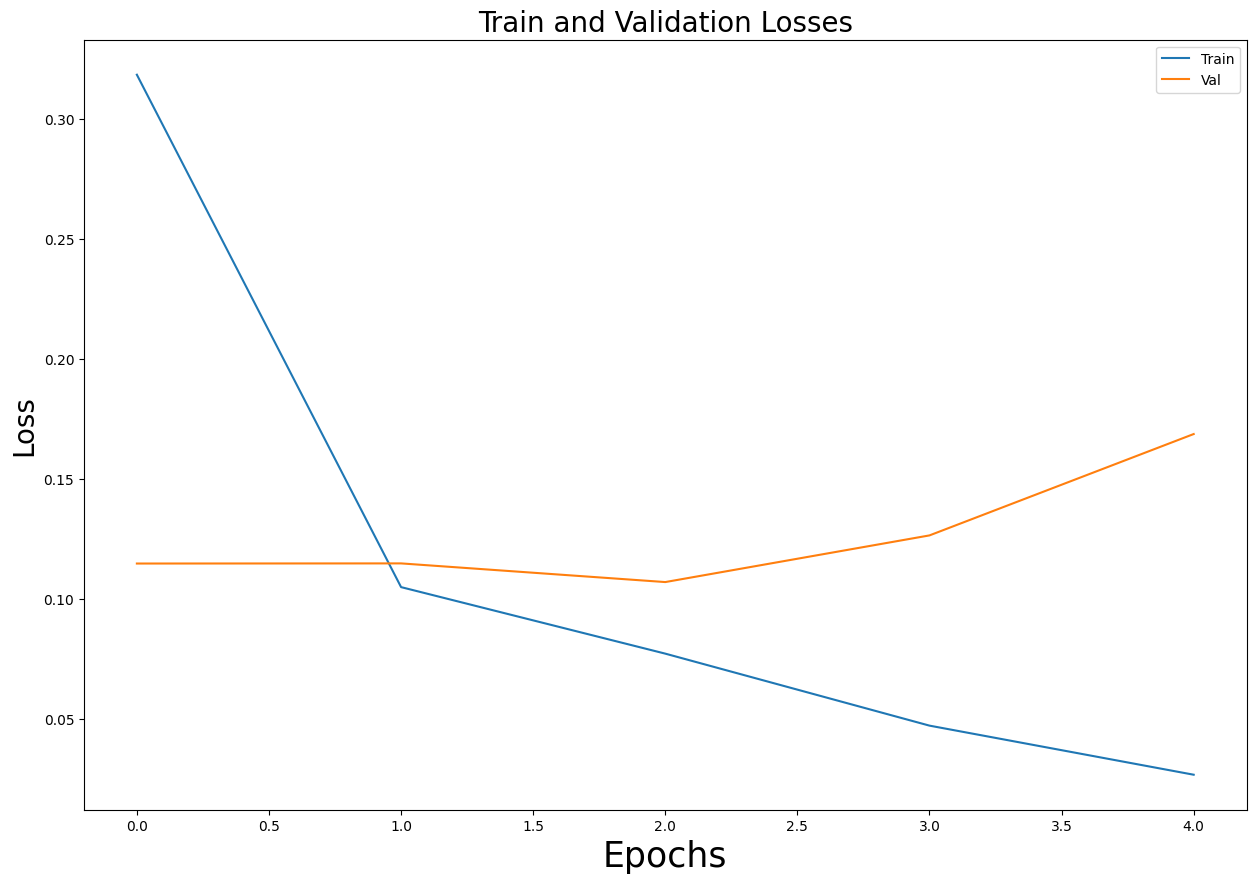

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')